In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import dataset_wrapper
import visualize
import parsing
import numpy as np
from sklearn.metrics import jaccard_similarity_score

In [2]:
%matplotlib inline 


In [3]:
# make function handle i and o countour types

def batch_wrapper_keys(_linkfile_path, contour_type='o'):
    '''main function to call, returns DataSet Obeject'''
    all_path2contours = []
    contour_files, _, pairs = dataset_wrapper.get_file_pairs(_linkfile_path)
    contour_paths = ['./final_data/contourfiles/'+ x +'/'+ contour_type +'-contours' for x in contour_files]

    for _path in contour_paths:
        path2contours, contours_avail = dataset_wrapper.get_files_in_path(_path)
        all_path2contours.extend([path2contours + '/' + x for x in contours_avail])

    # fix: memoize for scalability
    dicoms_paths = [pairs[dataset_wrapper.match_dicom_path(x)[0]] + '/' + dataset_wrapper.match_dicom_path(x)[1] for x in all_path2contours]
    
    return dicoms_paths, all_path2contours

In [4]:
o=batch_wrapper_keys('/Users/mengningshang/Desktop/Dev_Env/medseg/final_data/link.csv',
                                contour_type='o')
i=batch_wrapper_keys('/Users/mengningshang/Desktop/Dev_Env/medseg/final_data/link.csv',
                                contour_type='i')

In [5]:
obatch=o
ibatch=i 

In [6]:
import sys

def match_contour_pairs(i, o):
    '''
    this pairs i and o countours
    returns tuples with dicom path as key and i,o countour path as value
    '''
    matching_dicoms=set(i[0]).intersection(o[0])
#     print(len(matching_dicoms),len(i[0]), len(o[0]), matching_dicoms)
    i_zip=zip(i[0],i[1])
    o_zip=zip(o[0],o[1])
    i = [a for a in i_zip if a[0] in matching_dicoms]
    o = [a for a in o_zip if a[0] in matching_dicoms]
    print(len(i), len(o))
    i_dicom, i_contour = zip(*list(i))
    o_dicom, o_contour = zip(*list(o))
    i = zip(i_dicom,i_contour)
    o = zip(o_dicom,o_contour)
    return i,o

i_f, o_f = match_contour_pairs(i,o)

46 46


In [7]:
# make dictionary for ease of use
odict=dict((x, y) for x, y in o_f)
idict=dict((x, y) for x, y in i_f)
print(list(idict.keys()))


['SCD0000101/119.dcm', 'SCD0000101/99.dcm', 'SCD0000101/159.dcm', 'SCD0000101/79.dcm', 'SCD0000101/219.dcm', 'SCD0000101/199.dcm', 'SCD0000101/139.dcm', 'SCD0000101/59.dcm', 'SCD0000101/179.dcm', 'SCD0000201/220.dcm', 'SCD0000201/100.dcm', 'SCD0000201/80.dcm', 'SCD0000201/140.dcm', 'SCD0000201/60.dcm', 'SCD0000201/180.dcm', 'SCD0000201/200.dcm', 'SCD0000201/120.dcm', 'SCD0000201/160.dcm', 'SCD0000301/100.dcm', 'SCD0000301/20.dcm', 'SCD0000301/80.dcm', 'SCD0000301/140.dcm', 'SCD0000301/60.dcm', 'SCD0000301/180.dcm', 'SCD0000301/200.dcm', 'SCD0000301/120.dcm', 'SCD0000301/40.dcm', 'SCD0000301/160.dcm', 'SCD0000401/100.dcm', 'SCD0000401/80.dcm', 'SCD0000401/140.dcm', 'SCD0000401/60.dcm', 'SCD0000401/180.dcm', 'SCD0000401/200.dcm', 'SCD0000401/120.dcm', 'SCD0000401/40.dcm', 'SCD0000401/160.dcm', 'SCD0000501/119.dcm', 'SCD0000501/99.dcm', 'SCD0000501/159.dcm', 'SCD0000501/79.dcm', 'SCD0000501/219.dcm', 'SCD0000501/199.dcm', 'SCD0000501/139.dcm', 'SCD0000501/59.dcm', 'SCD0000501/179.dcm']


In [8]:
def make_mask_sets():
    rings = {}
    oms = {}
    ims = {}
    extras={}
    for x in odict.keys():
        om=parsing.poly_to_mask(parsing.parse_contour_file(odict[x]), 256, 256)
        im=parsing.poly_to_mask(parsing.parse_contour_file(idict[x]), 256, 256)
#         print(sum(om*1-im*1))
#         print(x, om.shape,im.shape)
        rings[x]=om*1-im*1
        file_path=odict[x].split('/')[-3:]
        oms[x]={'mask': om*1,'file_path': file_path}
        ims[x]={'mask': im*1,'file_path': file_path}
        extras[x]=np.logical_not(om*1)#oms[x]['mask']

    
    return rings, oms, ims, extras

In [9]:
rings, oms, ims, extras = make_mask_sets()

In [10]:
def select_region(img, _mask):
    '''
    selects pixel values region according to mask
    '''
#     print(_mask.shape, img.shape)
    img=img['pixel_data']
    pixels = []
    for i in range(len(img)):
        for j in range(i):
            if _mask['mask'][i][j] !=0:
                pixels.append(img[i][j])
#     print(pixels)
    return pixels
                
        

In [11]:
len(rings.keys())

46

SCD0000101/139.dcm


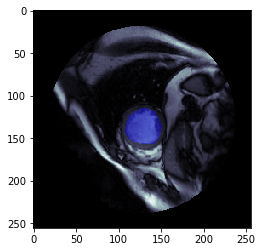

In [23]:
key = 'SCD0000101/139.dcm' #list(rings.keys())[11] #list(rings.keys())[11] #res['SCD0000501/199.dcm']
print(key)
dic = parsing.parse_dicom_file(dataset_wrapper.DATA_PATH+'/dicoms/'+key)
visualize.plot_overlay(dic, ims[key])  # quick visual check


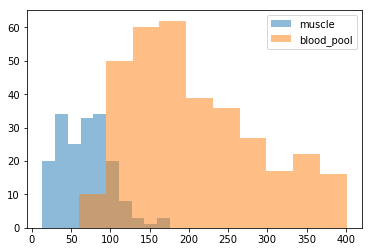

In [13]:
def plot_densityHist(_key, ims=ims, oms=oms):
    '''
    graphically compare ring and blood pool (inner) pixel density
    '''
    dicom = parsing.parse_dicom_file(dataset_wrapper.DATA_PATH+'/dicoms/'+_key)
    ring_crop = select_region(dicom, {'mask': rings[_key]})
    inner_crop = select_region(dicom, ims[_key])
    outter_crop = select_region(dicom, oms[_key])


    plt.hist(ring_crop, alpha=0.5, label='muscle') # bins,
    plt.hist(inner_crop, alpha=0.5, label='blood_pool')
    plt.legend(loc='upper right')
    plt.show()


plot_densityHist('SCD0000101/219.dcm')


In [28]:
def iou_jaccard(tpix, ipix):
    intersection = tpix.intersection(ipix)
    union = tpix.union(ipix)
    jaccard = len(intersection)/float(len(union)) # prevent overflow
    return jaccard

def mask_to_pixel_index(_mask):
    pixels_index = set([])
    for i in range(len(_mask)):
        for j in range(i):
            if _mask[i][j] !=0:
                pixels_index.add((i,j))
    return pixels_index
                

    k2 = 'SCD0000401/180.dcm'

def iou_score(key, bmask, _ims):
    kt=key
    tdic = parsing.parse_dicom_file(dataset_wrapper.DATA_PATH+'/dicoms/'+kt)
    tpix = mask_to_pixel_index(bmask)
    ipix = mask_to_pixel_index(_ims[kt]['mask'])
    pad_to=max(len(bmask), len(bmask))
    mask_to_pixel_index(_ims[kt]['mask'])
    return iou_jaccard(tpix,ipix)


In [15]:
from skimage.filters import threshold_minimum,threshold_minimum, threshold_otsu, try_all_threshold
from PIL import Image, ImageDraw
from scipy.stats import ks_2samp
def visual_report(_key, white_background=True, plot=False):
    '''
    generate diagnostic stats and plots for a given dicom
    '''
    dicom= parsing.parse_dicom_file(dataset_wrapper.DATA_PATH+'/dicoms/'+_key)
    outter_crop = select_region(dicom, oms[_key])
    val =threshold_otsu(np.asarray(outter_crop))
    image_ = dicom['pixel_data']
    
    thresh_min=val
    binary_min = image_*oms[_key]['mask'] > val
    binary_min_whiteoutExtra=binary_min+extras[_key]
    thresh_crop = select_region(dicom, {'mask': binary_min})
    inner_crop = select_region(dicom, ims[_key])
#     visualize.plot_overlay(dicom, thresh_crop, _name=oms[_key]['file_path'])
#     visualize.plot_overlay(dicom, inner_crop, _name=oms[_key]['file_path'])


    if plot ==True:

        visualize.plot_overlay(dicom, {'mask': binary_min}, _name=oms[_key]['file_path'])
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))

        ax[0, 0].imshow(image_, cmap=plt.cm.gray)
        ax[0, 0].set_title('Original')

        ax[0, 1].hist(image_.ravel(), bins=256)
        ax[0, 1].set_title('Histogram')

        ax[1, 0].imshow(binary_min_whiteoutExtra, cmap=plt.cm.gray)
        if white_background:
            ax[1, 0].imshow(binary_min_whiteoutExtra, cmap=plt.cm.gray)
        ax[1, 0].set_title('Thresholded (min)')
        ax[1, 0].imshow(ims[_key]['mask'], alpha=.4, cmap=visualize.CMAPBLUE)

        ax[1, 1].hist(image_.ravel(), bins=256)
        ax[1, 1].axvline(thresh_min, color='r')


        for a in ax[:, 0]:
            a.axis('off')
        plt.show()
    
 Ω    return _key, ks_2samp(inner_crop, thresh_crop), iou_score(_key,binary_min, ims), ks_2samp(inner_crop, thresh_crop)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<matplotlib.figure.Figure at 0x11ce32978>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11db58f28>,
       dtype=object))

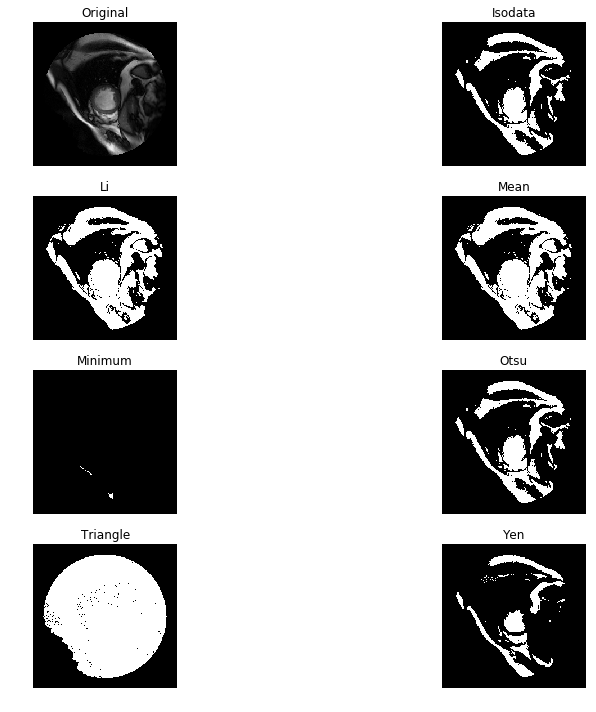

In [26]:
try_all_threshold(dic['pixel_data'], figsize=(15, 10), verbose=True)
# dic

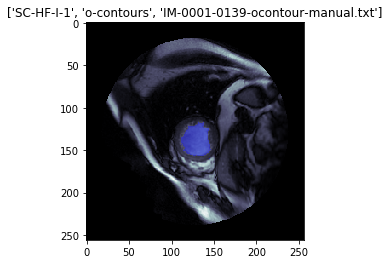

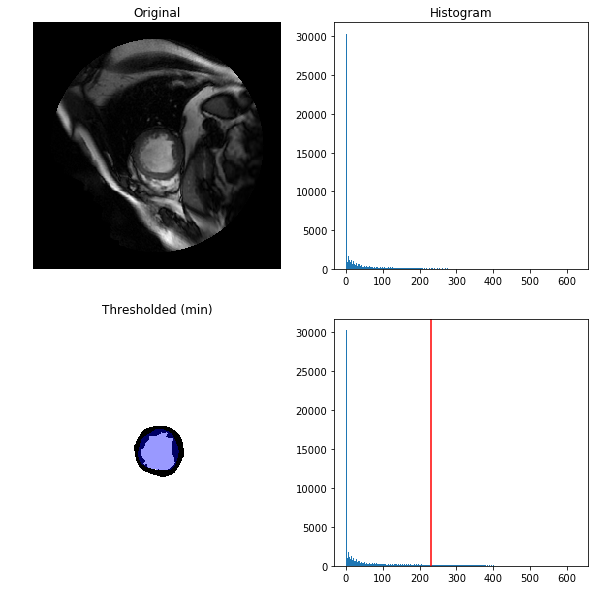

Ks_2sampResult(statistic=0.19607843137254902, pvalue=2.7427586156123836e-14) iou: 0.8013029315960912 Ks_2sampResult(statistic=0.19607843137254902, pvalue=2.7427586156123836e-14)


('SCD0000101/139.dcm',
 Ks_2sampResult(statistic=0.19607843137254902, pvalue=2.7427586156123836e-14),
 0.8013029315960912,
 Ks_2sampResult(statistic=0.19607843137254902, pvalue=2.7427586156123836e-14))

In [29]:
visual_report('SCD0000101/139.dcm', plot=True)

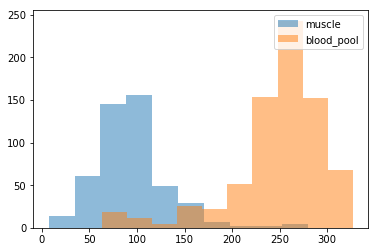

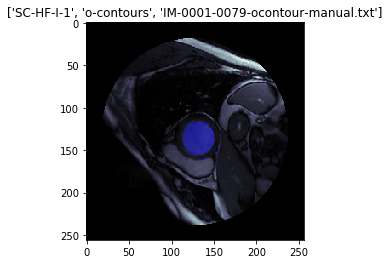

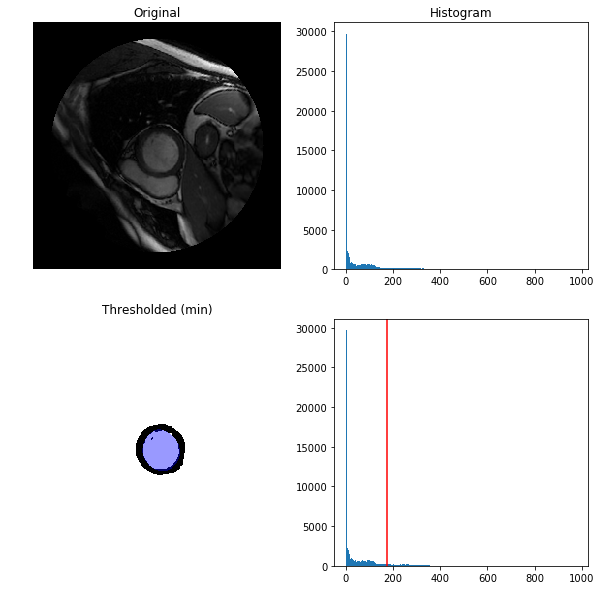

Ks_2sampResult(statistic=0.09066666666666667, pvalue=0.004954731716717515) iou: 0.8961892247043364


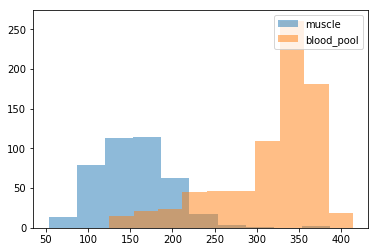

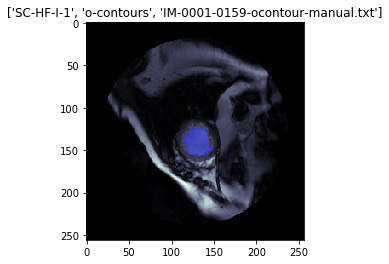

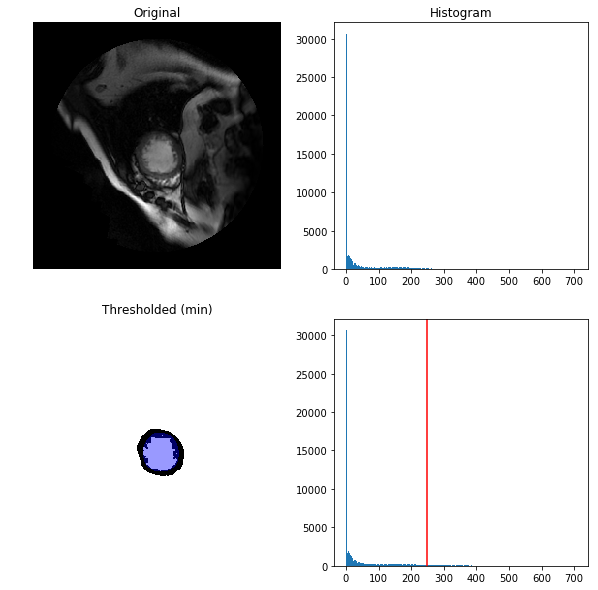

Ks_2sampResult(statistic=0.14973958333333334, pvalue=1.923471946910689e-07) iou: 0.8404118404118404


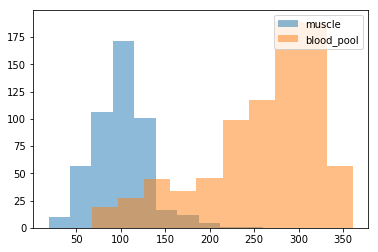

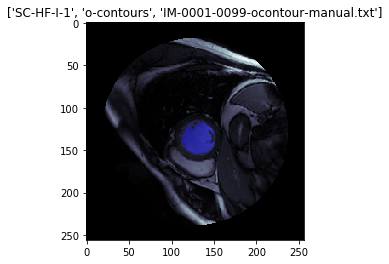

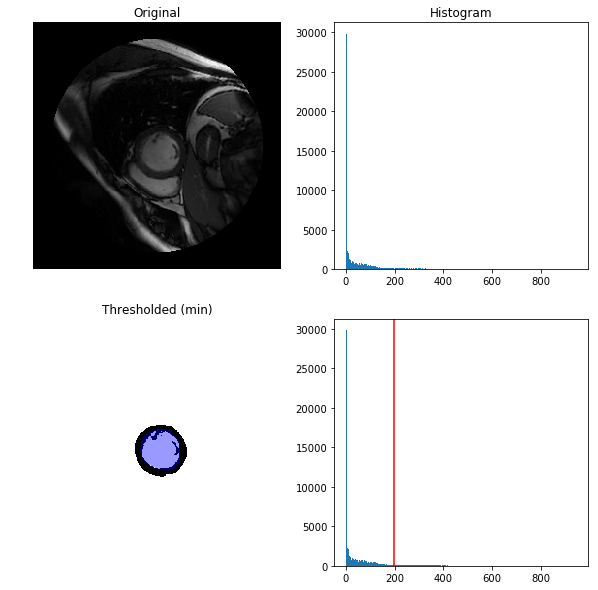

Ks_2sampResult(statistic=0.17274939172749393, pvalue=3.088433199072634e-10) iou: 0.8222490931076178


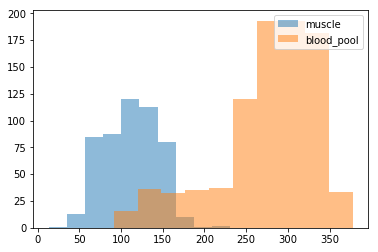

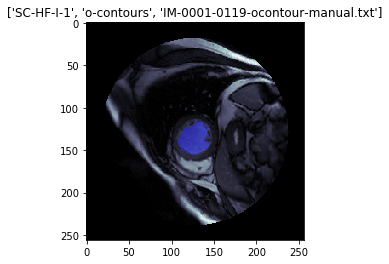

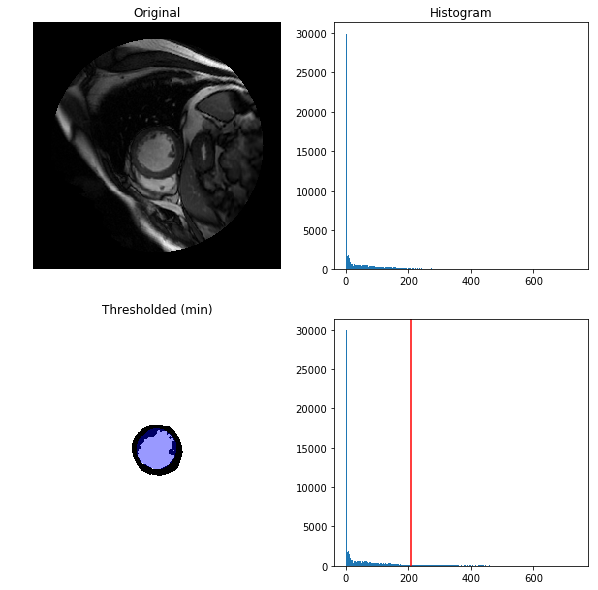

Ks_2sampResult(statistic=0.1402508551881414, pvalue=1.8947709647188846e-07) iou: 0.8577929465301479


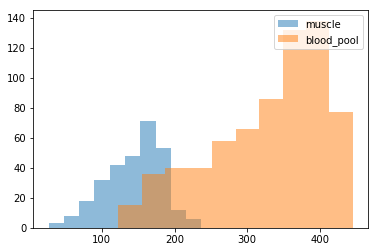

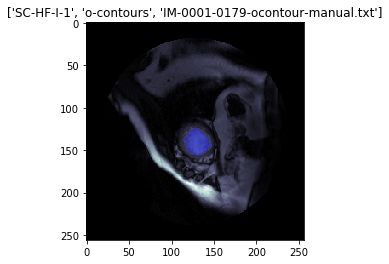

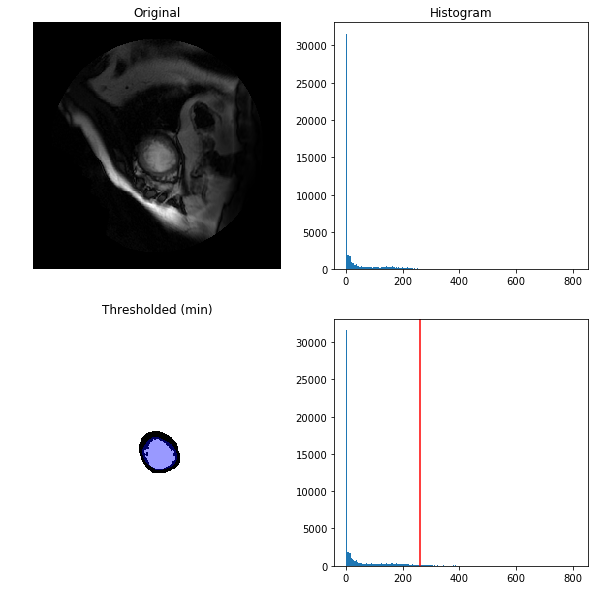

Ks_2sampResult(statistic=0.21220930232558138, pvalue=1.8618976900370743e-12) iou: 0.7877906976744186


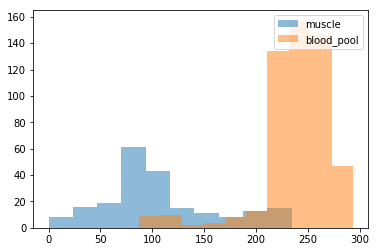

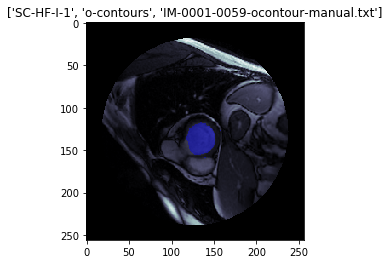

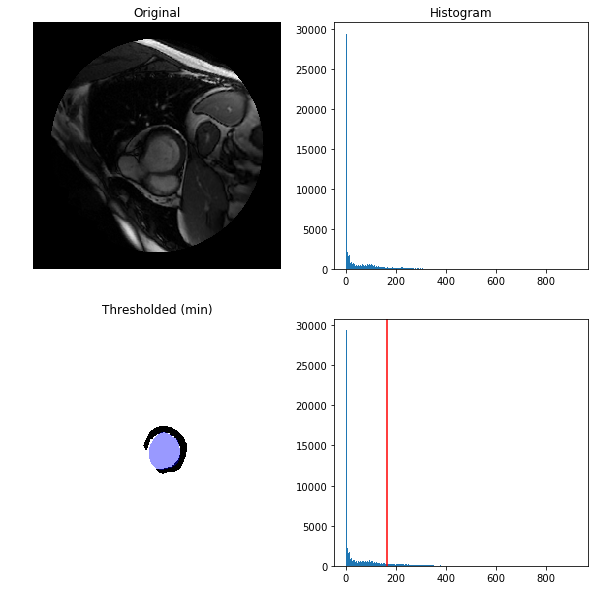

Ks_2sampResult(statistic=0.04716981132075472, pvalue=0.5818549023476994) iou: 0.8920353982300885


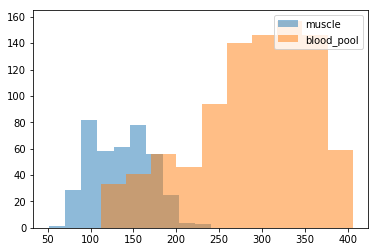

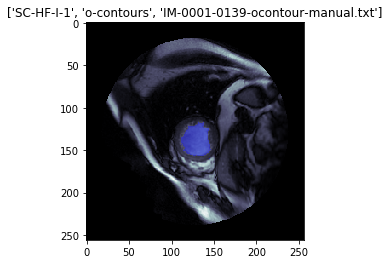

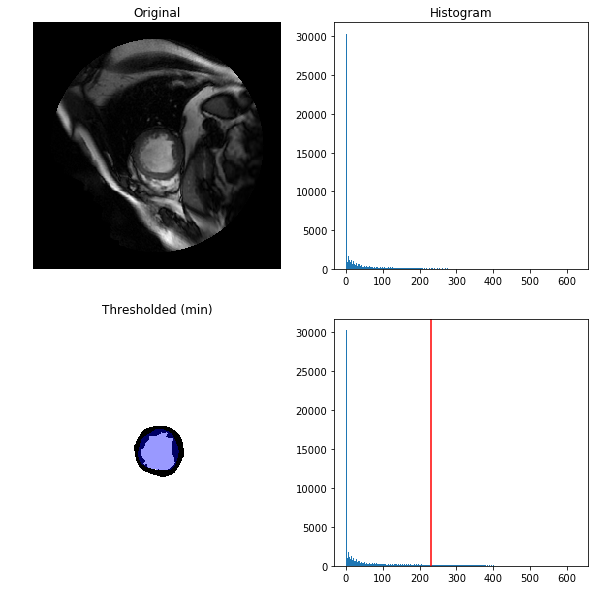

Ks_2sampResult(statistic=0.19607843137254902, pvalue=2.7427586156123836e-14) iou: 0.8013029315960912


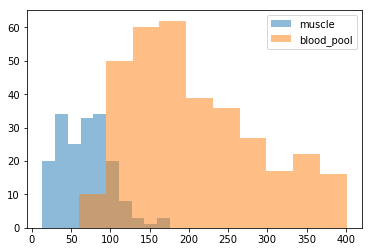

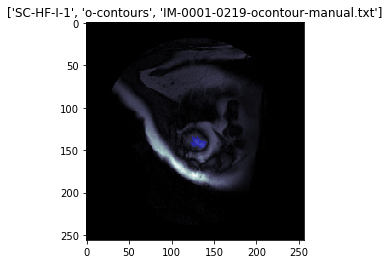

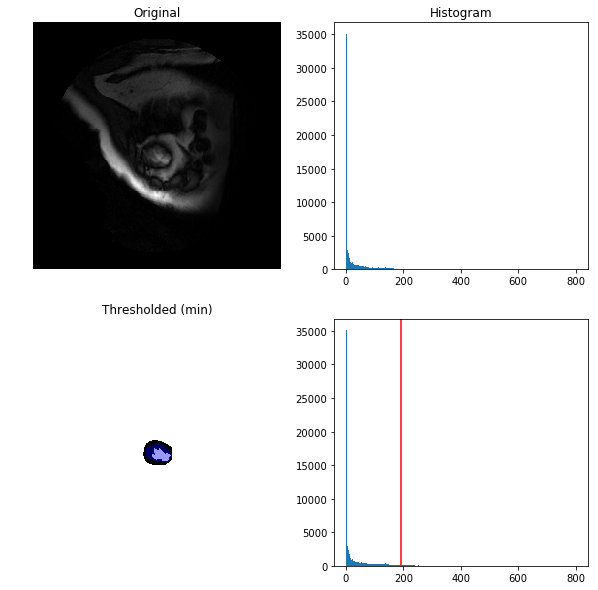

Ks_2sampResult(statistic=0.5250737463126843, pvalue=3.187846582588472e-27) iou: 0.4749262536873156


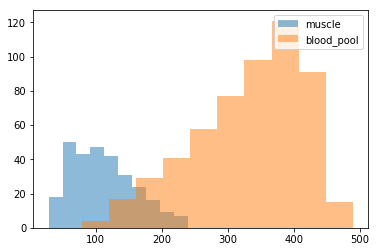

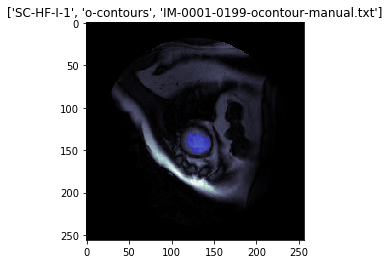

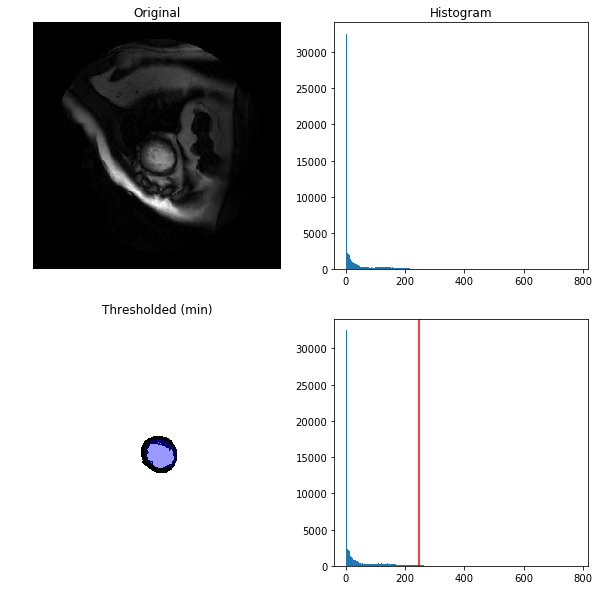

Ks_2sampResult(statistic=0.19056261343012704, pvalue=2.5123480548856657e-08) iou: 0.809437386569873


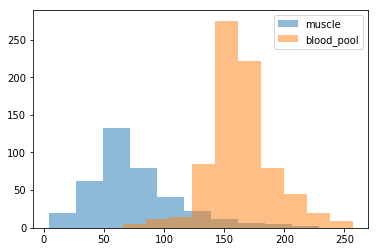

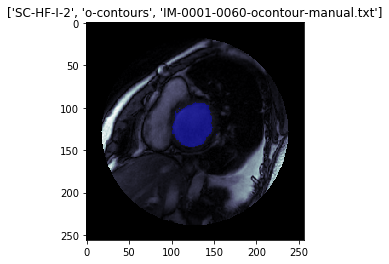

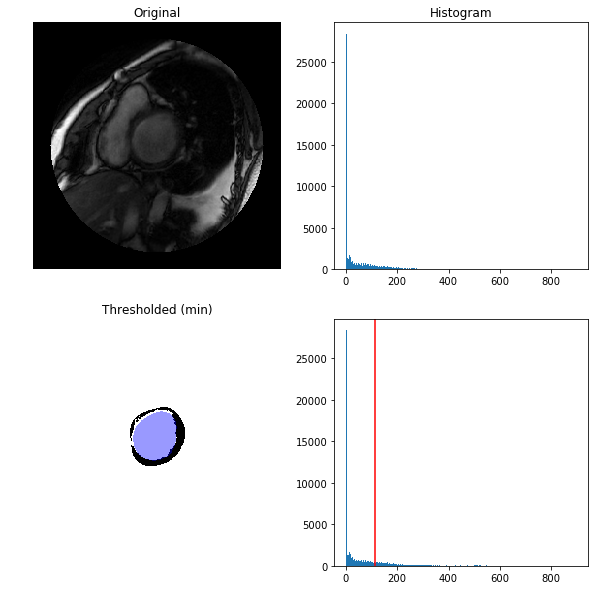

Ks_2sampResult(statistic=0.02741514360313316, pvalue=0.9274956256853897) iou: 0.910757946210269


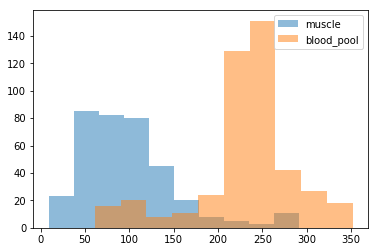

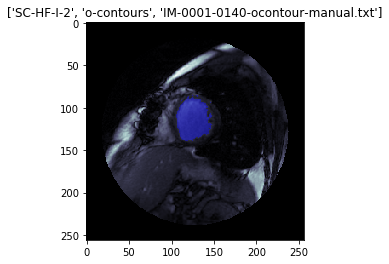

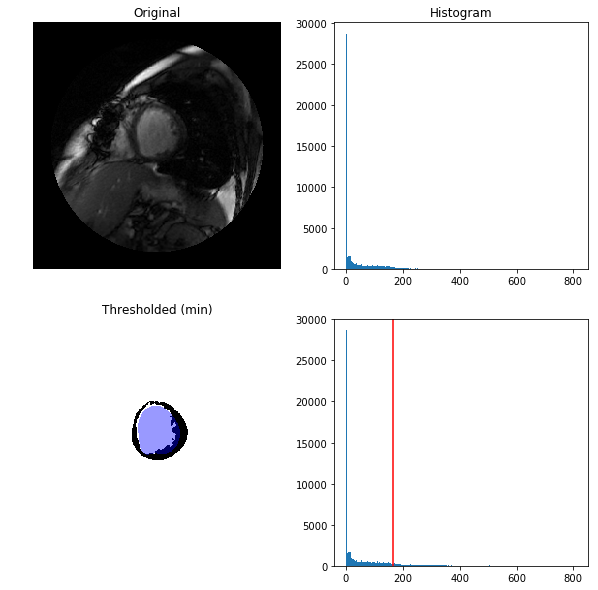

Ks_2sampResult(statistic=0.11883408071748879, pvalue=0.0038206613869173588) iou: 0.8204592901878914


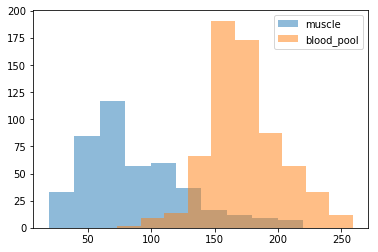

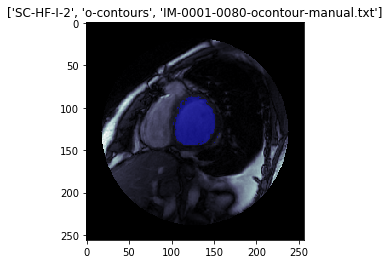

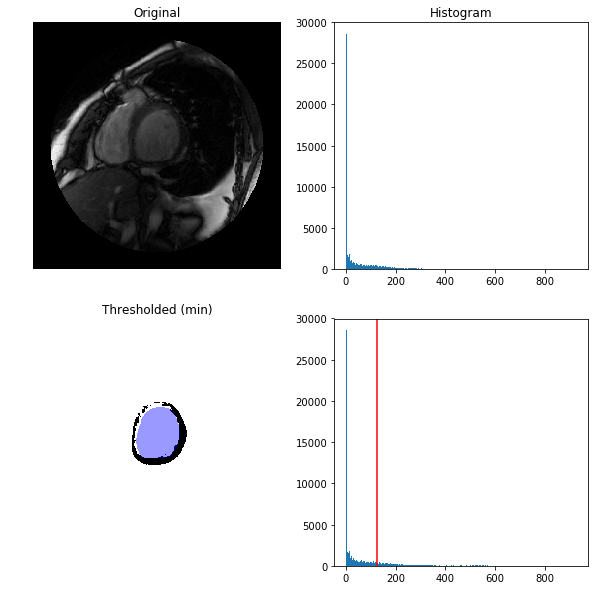

Ks_2sampResult(statistic=0.031055900621118012, pvalue=0.8987092361858164) iou: 0.8690807799442897


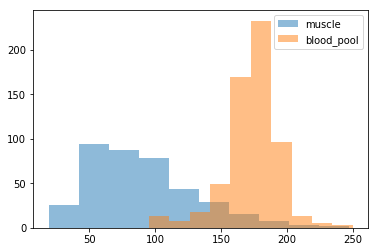

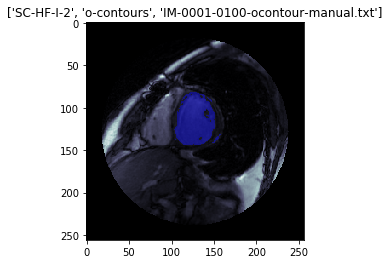

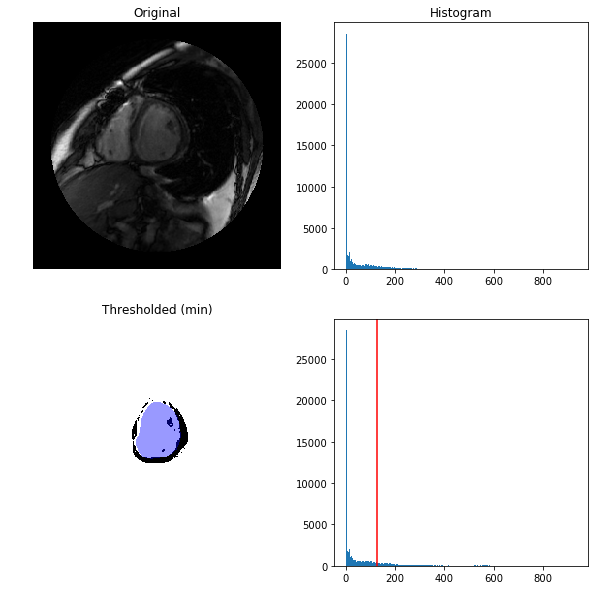

Ks_2sampResult(statistic=0.03453947368421053, pvalue=0.8390908258543524) iou: 0.8645066273932254


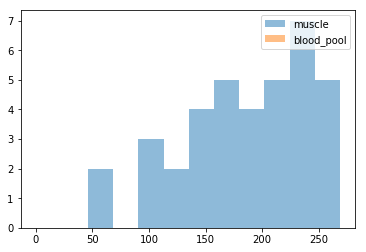

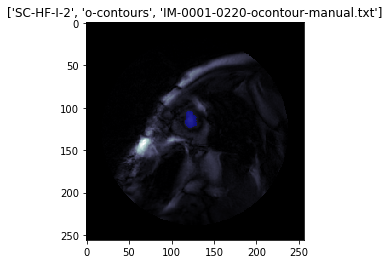

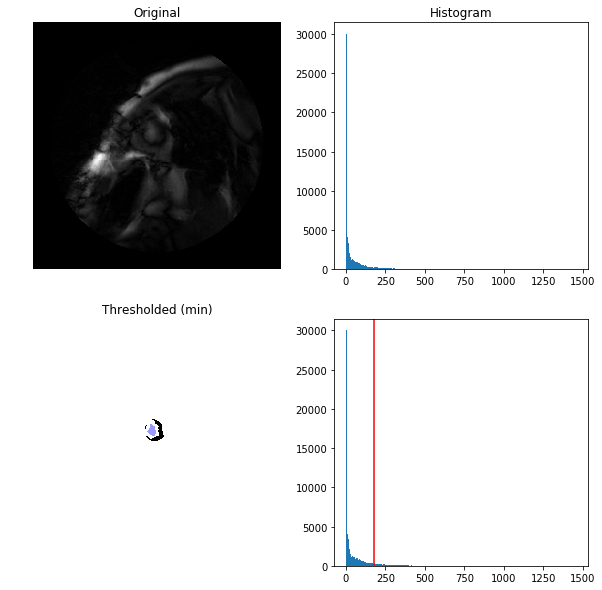

/Users/mengningshang/Desktop/Dev_Env/carAI/CarND-Alexnet-Feature-Extraction/wcd-ml-b2/lib/python3.6/site-packages/scipy/stats/stats.py:4760: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/Users/mengningshang/Desktop/Dev_Env/carAI/CarND-Alexnet-Feature-Extraction/wcd-ml-b2/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/mengningshang/Desktop/Dev_Env/carAI/CarND-Alexnet-Feature-Extraction/wcd-ml-b2/lib/python3.6/site-packages/scipy/stats/stats.py:4766: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


Ks_2sampResult(statistic=nan, pvalue=nan) iou: 0.0


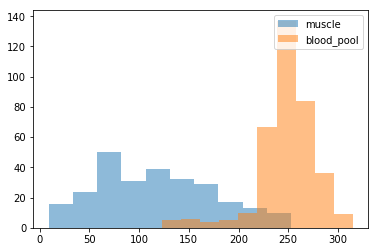

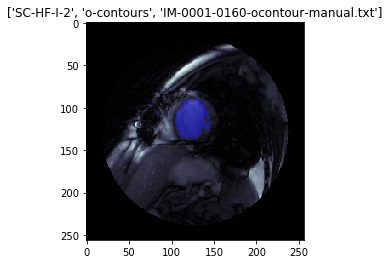

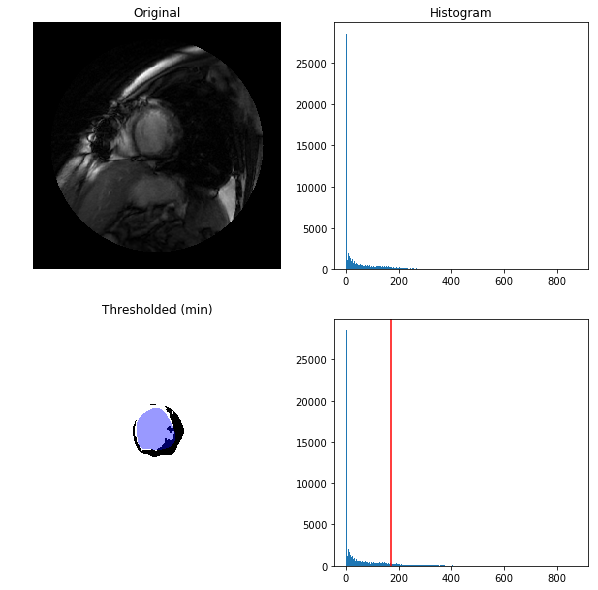

Ks_2sampResult(statistic=0.05853476666873794, pvalue=0.5207475388985128) iou: 0.8450363196125908


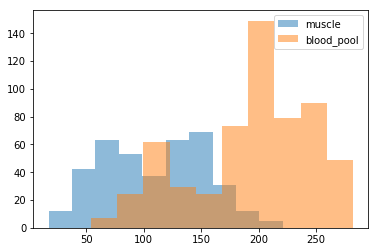

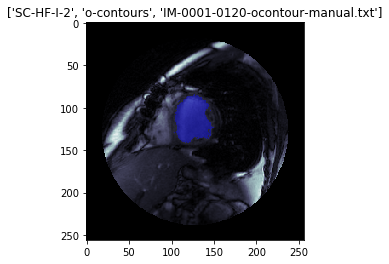

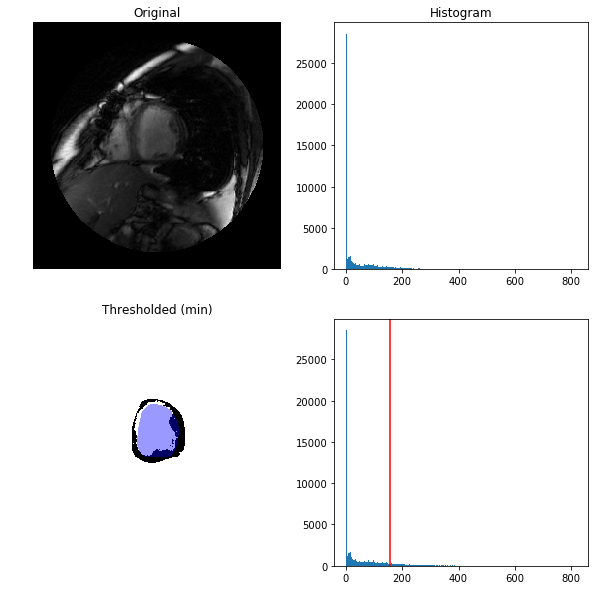

Ks_2sampResult(statistic=0.22866894197952217, pvalue=6.776339087079762e-13) iou: 0.710691823899371


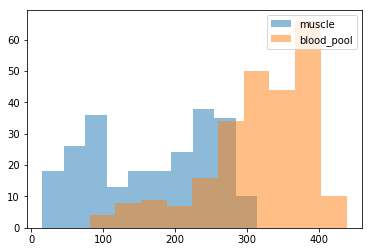

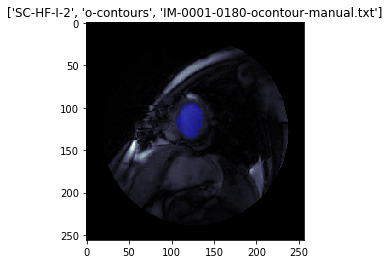

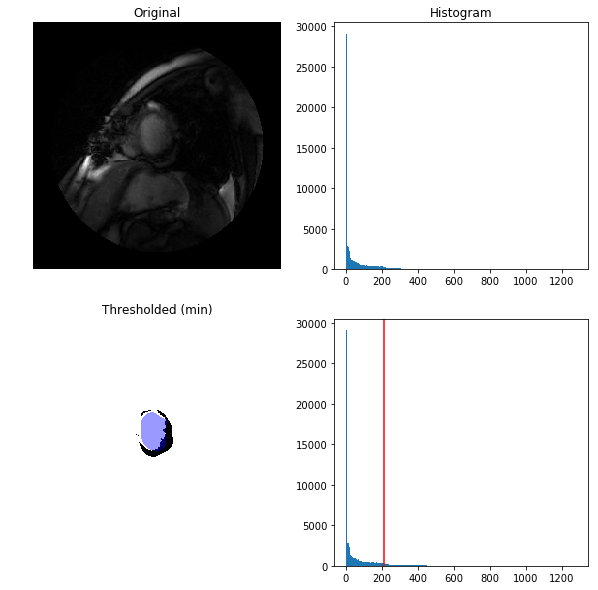

Ks_2sampResult(statistic=0.14974454017231015, pvalue=0.0032541258608668974) iou: 0.6473988439306358


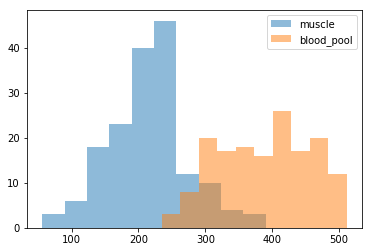

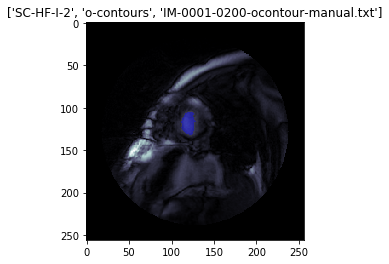

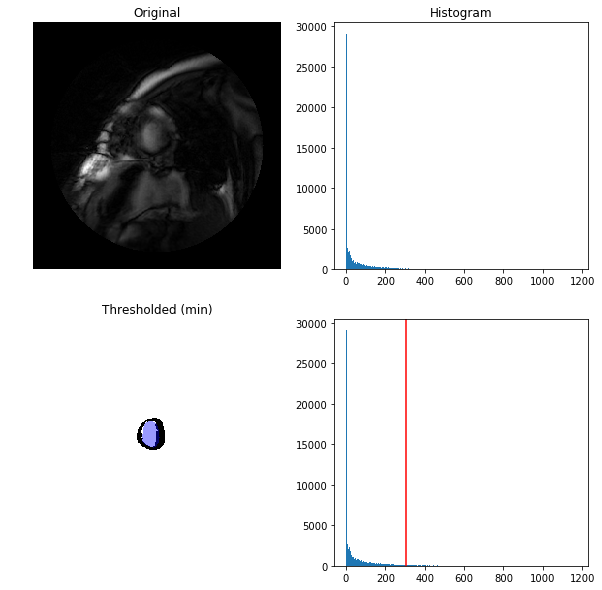

Ks_2sampResult(statistic=0.12738853503184713, pvalue=0.1577273973114557) iou: 0.8203592814371258


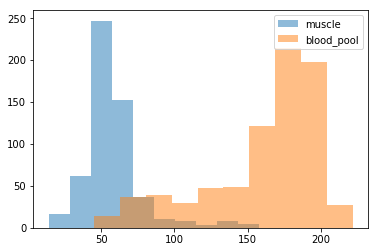

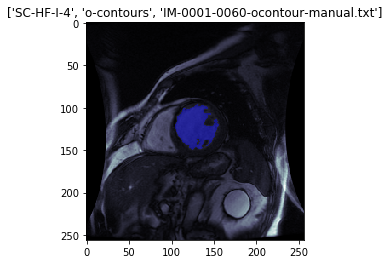

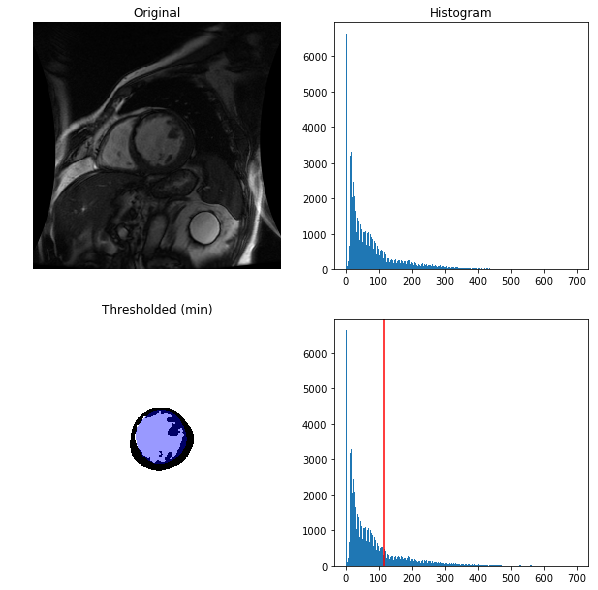

Ks_2sampResult(statistic=0.16087516087516088, pvalue=1.3550662324648827e-08) iou: 0.8242730720606827


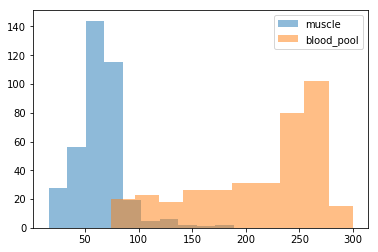

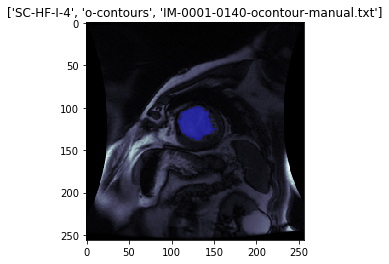

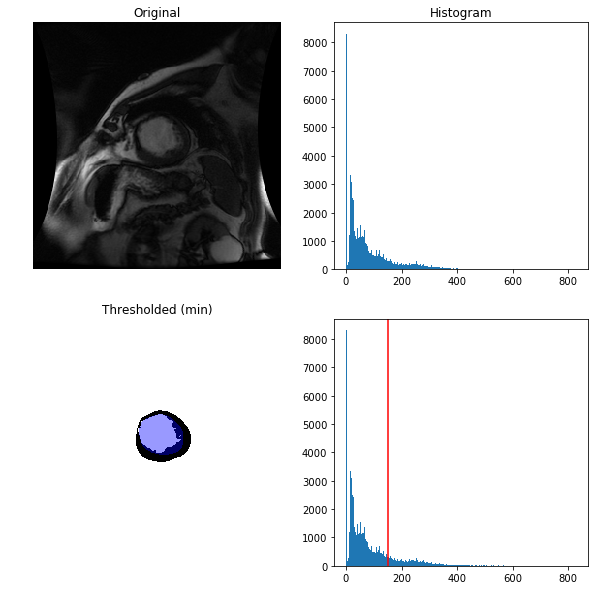

Ks_2sampResult(statistic=0.1989247311827957, pvalue=2.8665600907100636e-06) iou: 0.7925531914893617


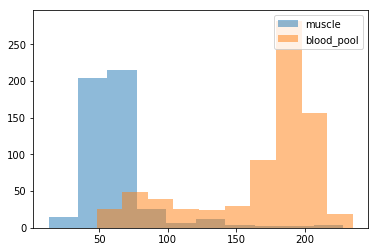

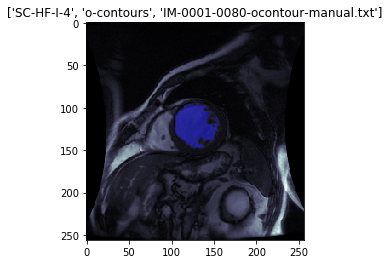

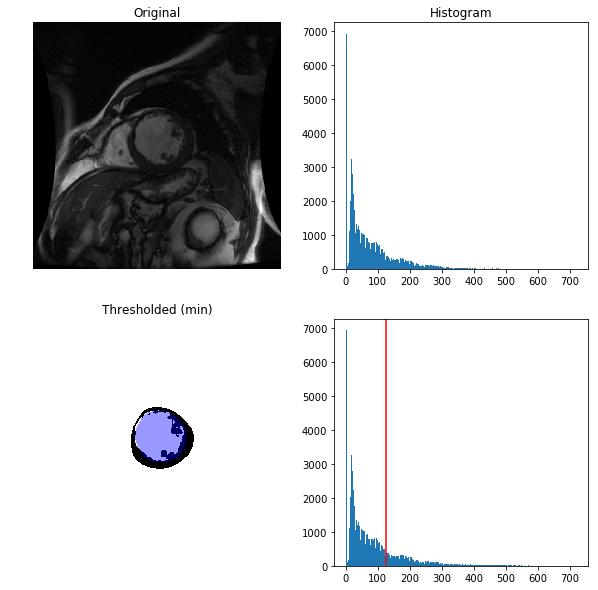

Ks_2sampResult(statistic=0.1911170928667564, pvalue=2.5826630855714996e-11) iou: 0.7866492146596858


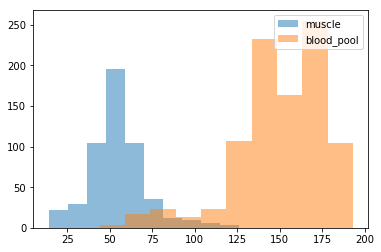

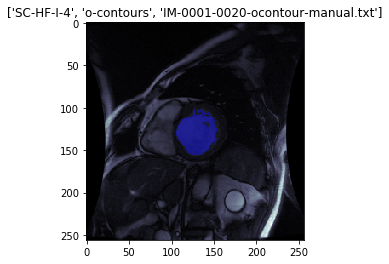

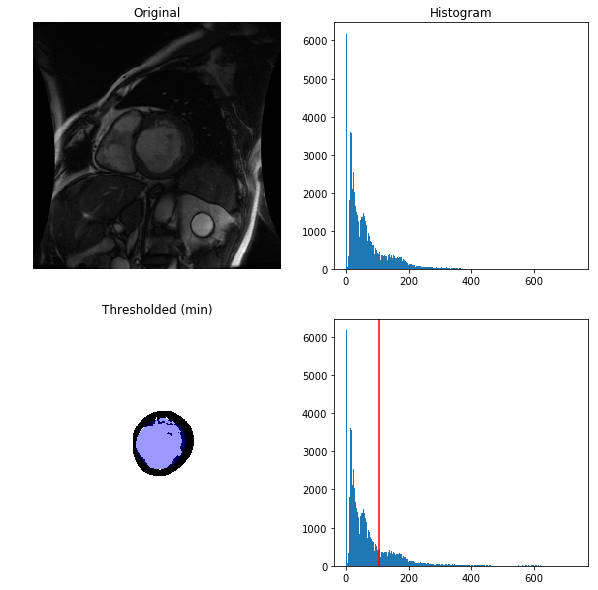

Ks_2sampResult(statistic=0.06263269639065817, pvalue=0.052785122586989225) iou: 0.9294736842105263


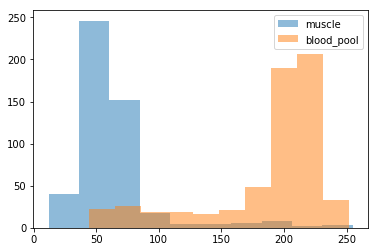

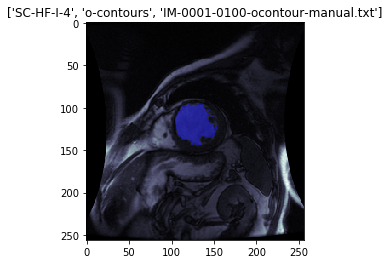

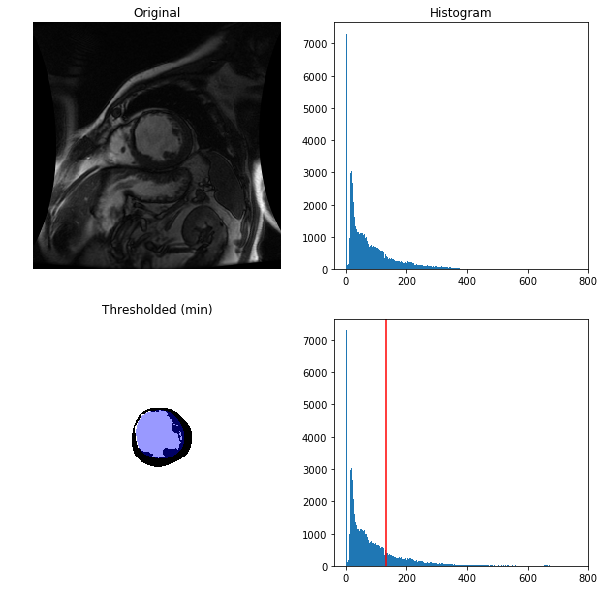

Ks_2sampResult(statistic=0.15448504983388706, pvalue=2.2503645946478576e-06) iou: 0.8130990415335463


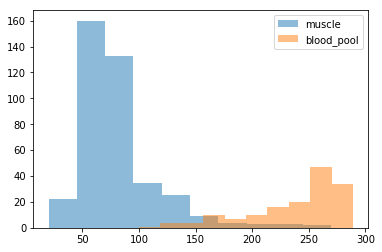

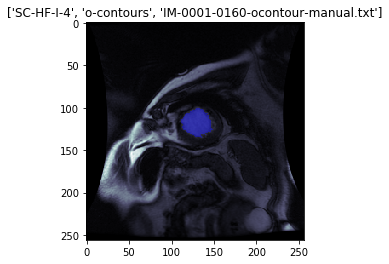

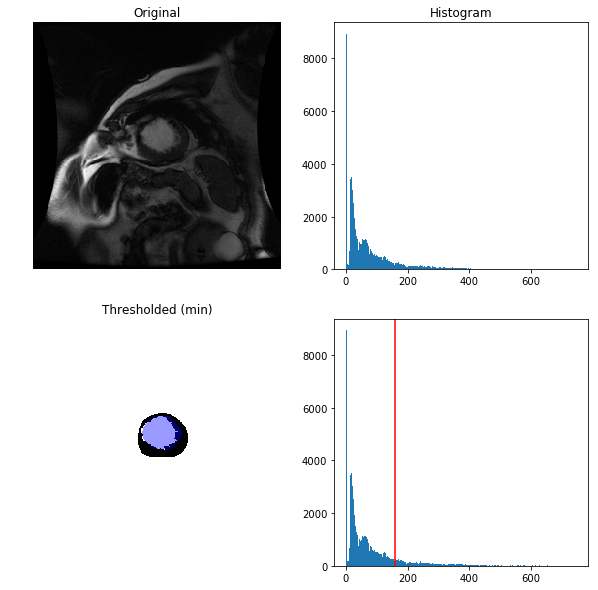

Ks_2sampResult(statistic=0.06535947712418301, pvalue=0.8825205785968501) iou: 0.8461538461538461


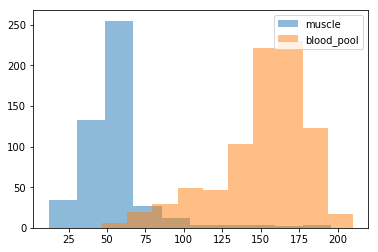

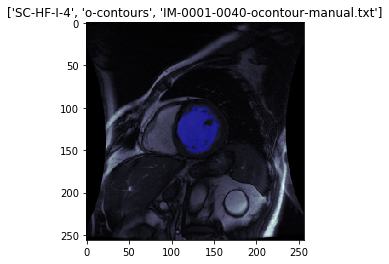

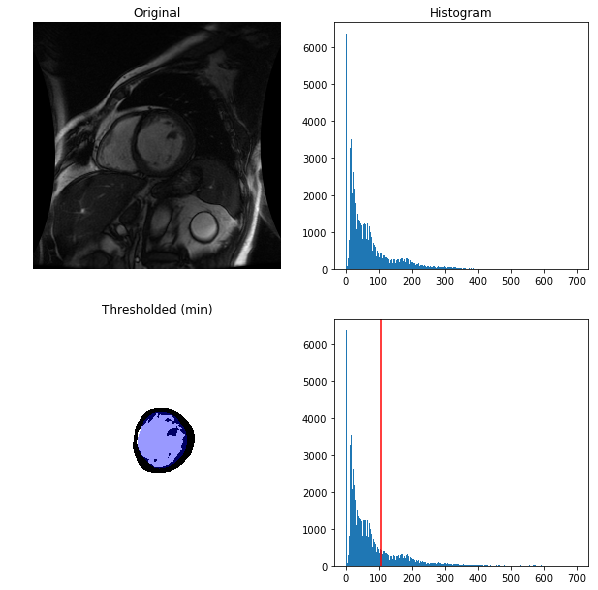

Ks_2sampResult(statistic=0.09574468085106383, pvalue=0.0010644098062399798) iou: 0.8874709976798144


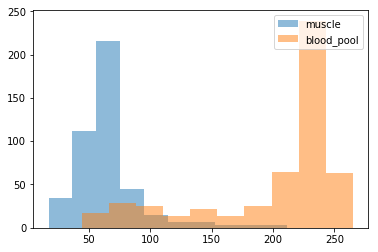

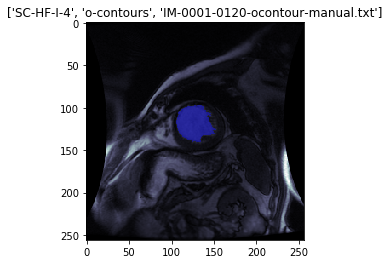

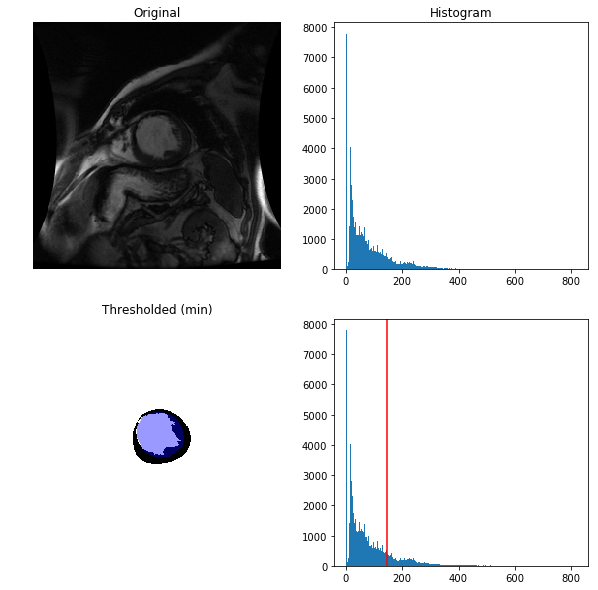

Ks_2sampResult(statistic=0.1875, pvalue=1.1812102179607453e-07) iou: 0.7954110898661568


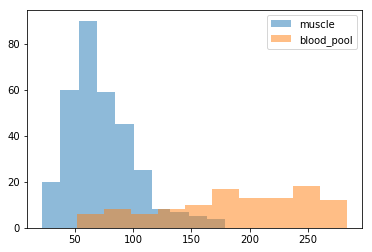

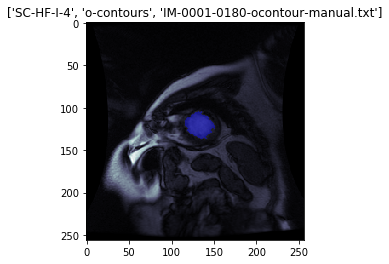

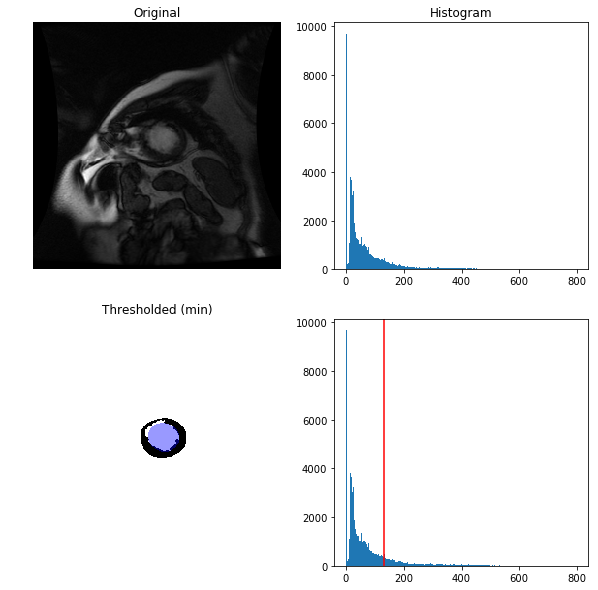

Ks_2sampResult(statistic=0.21621621621621623, pvalue=0.011531659522234464) iou: 0.6904761904761905


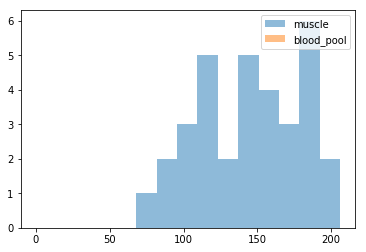

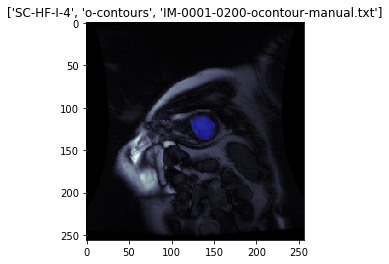

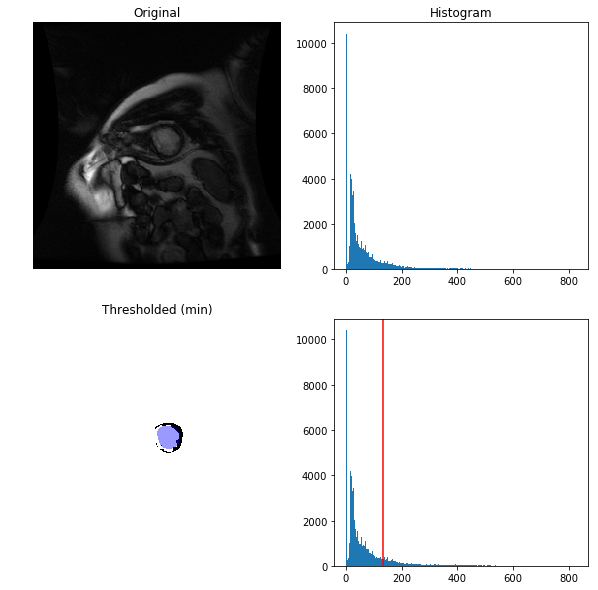

Ks_2sampResult(statistic=nan, pvalue=nan) iou: 0.0


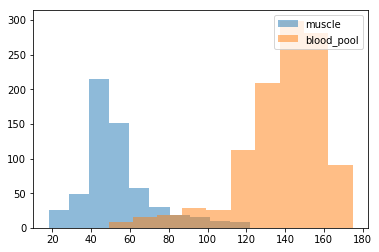

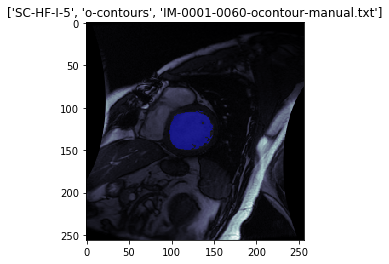

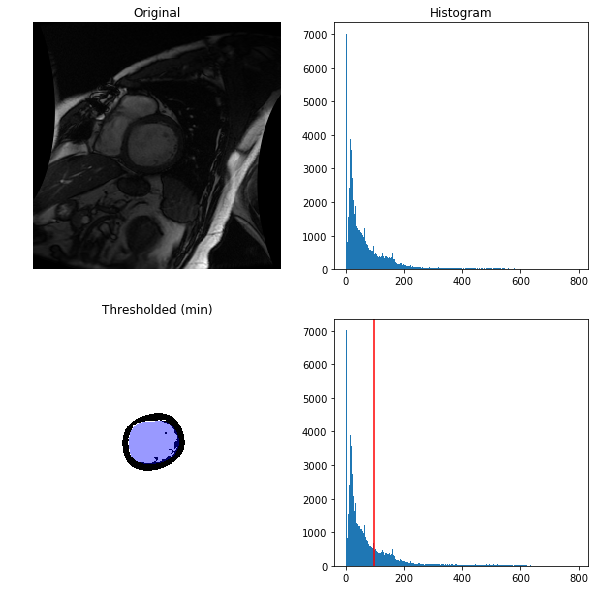

Ks_2sampResult(statistic=0.06347746090156393, pvalue=0.02645608608859466) iou: 0.919602529358627


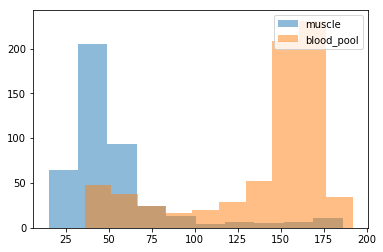

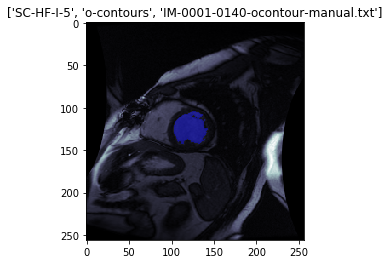

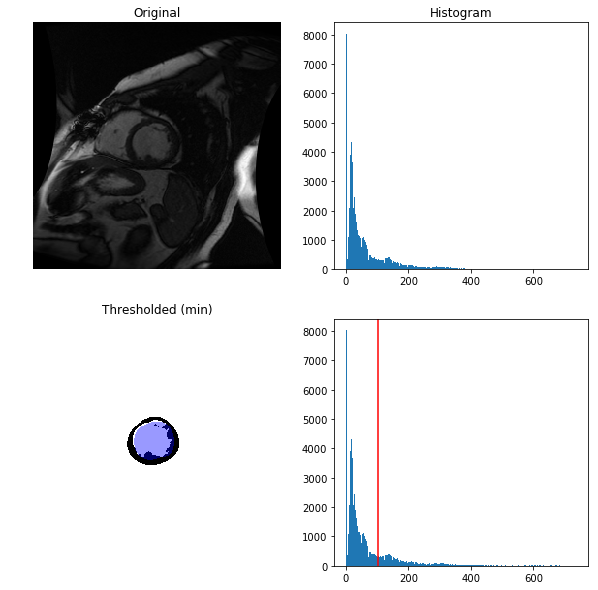

Ks_2sampResult(statistic=0.18857142857142858, pvalue=1.45830178098309e-10) iou: 0.773841961852861


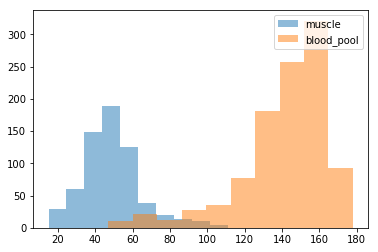

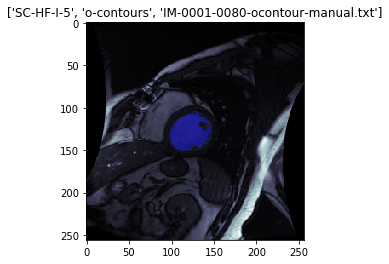

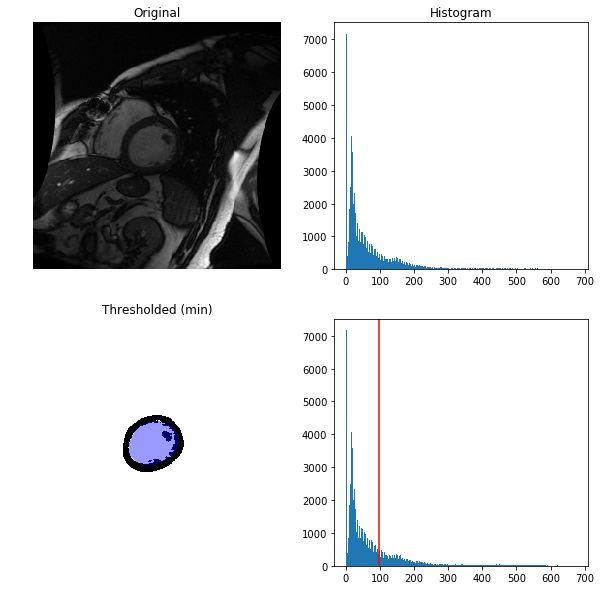

Ks_2sampResult(statistic=0.06846673095467695, pvalue=0.017062980365123277) iou: 0.9235181644359465


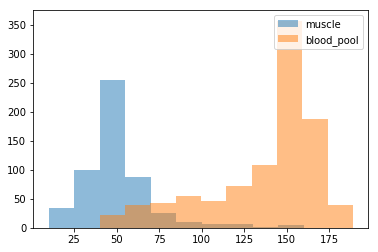

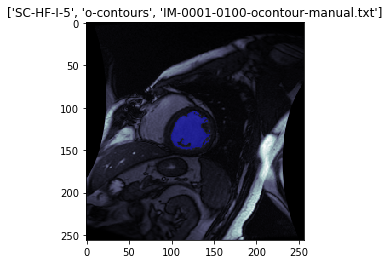

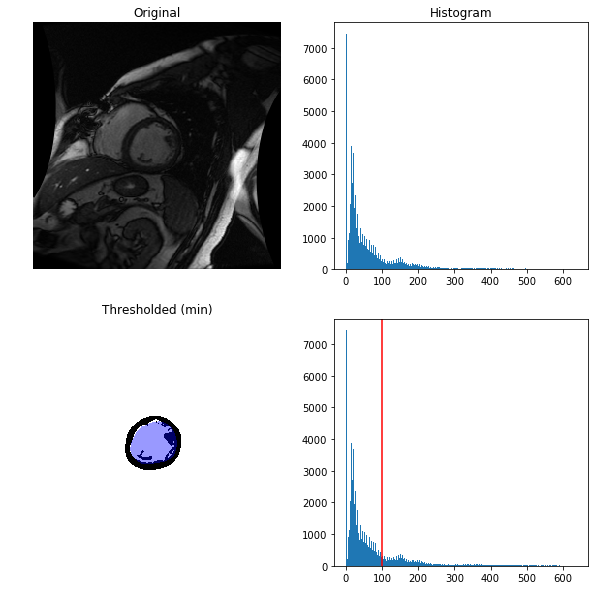

Ks_2sampResult(statistic=0.1652892561983471, pvalue=3.97040596321661e-11) iou: 0.8194726166328601


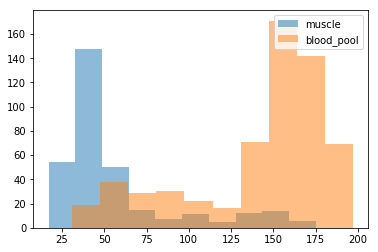

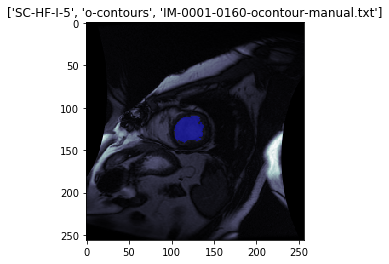

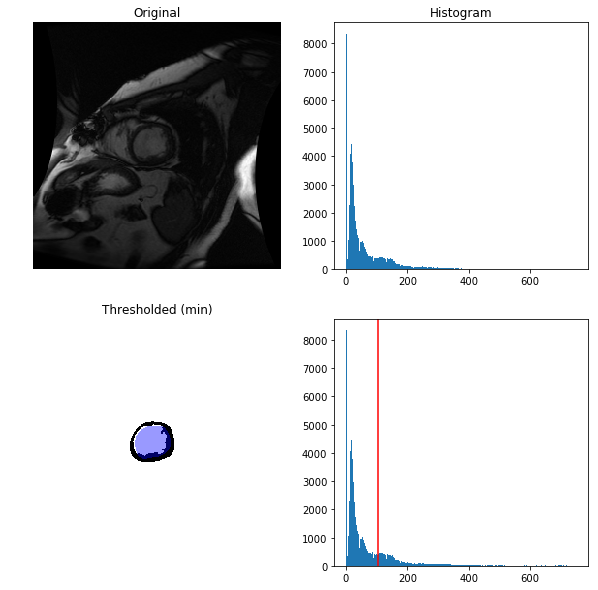

Ks_2sampResult(statistic=0.21087314662273476, pvalue=2.1975513016067763e-11) iou: 0.7414860681114551


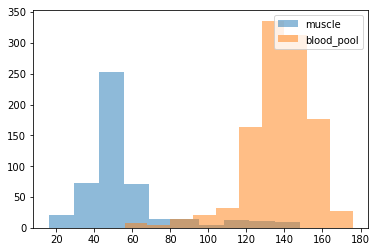

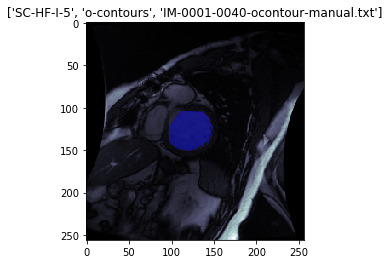

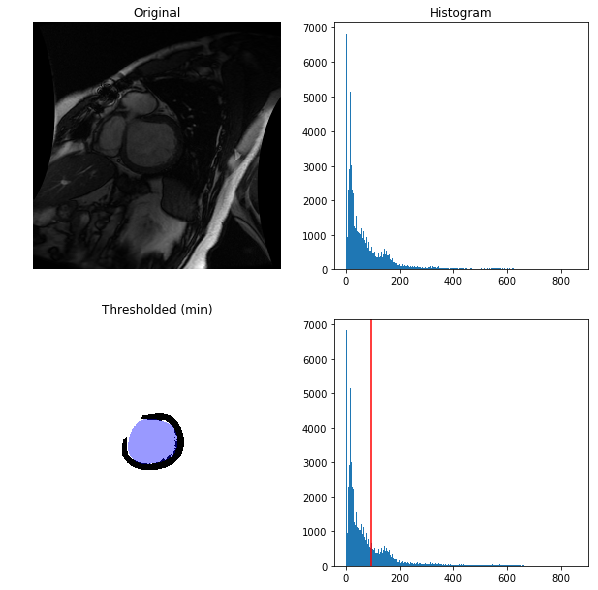

Ks_2sampResult(statistic=0.03555150410209663, pvalue=0.48696953376907626) iou: 0.9328621908127208


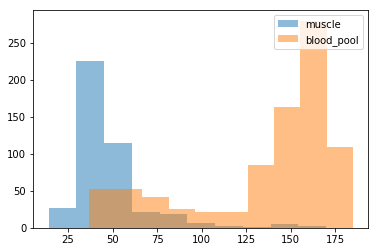

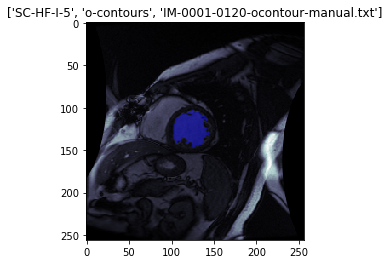

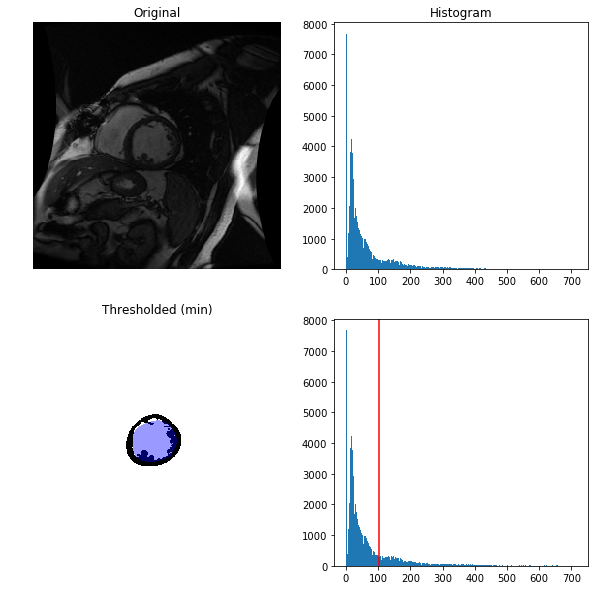

Ks_2sampResult(statistic=0.21570926143024619, pvalue=5.929336966841e-16) iou: 0.7716262975778547


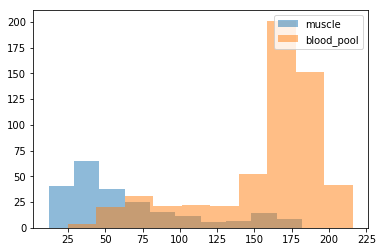

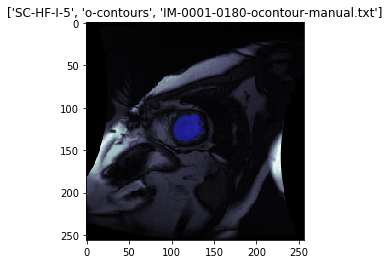

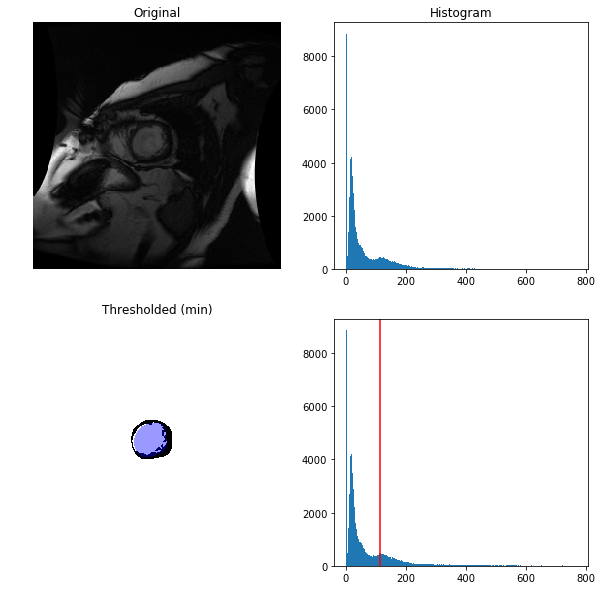

Ks_2sampResult(statistic=0.16283185840707964, pvalue=1.1087753086141617e-06) iou: 0.7883333333333333


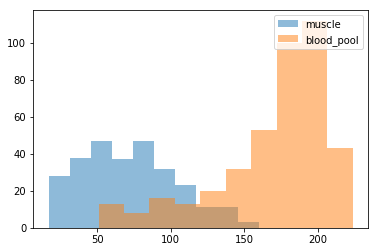

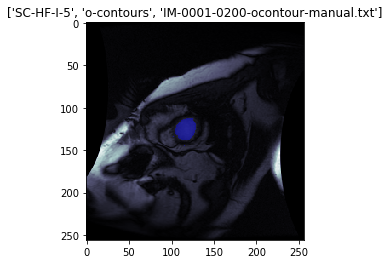

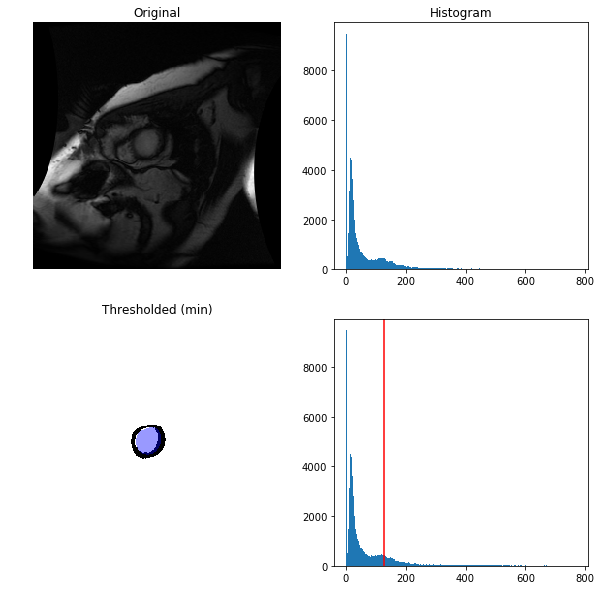

Ks_2sampResult(statistic=0.14146341463414633, pvalue=0.0007294500097772135) iou: 0.8243559718969555


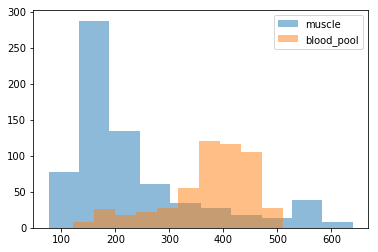

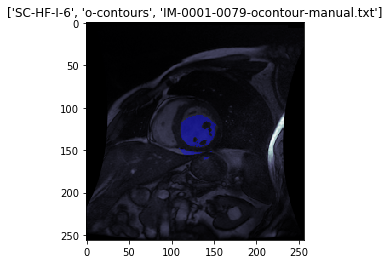

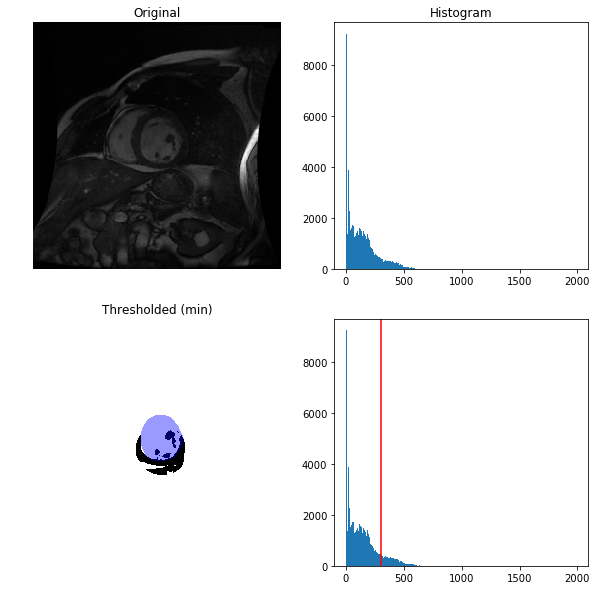

Ks_2sampResult(statistic=0.17234848484848486, pvalue=1.3198680584995774e-07) iou: 0.6511278195488722


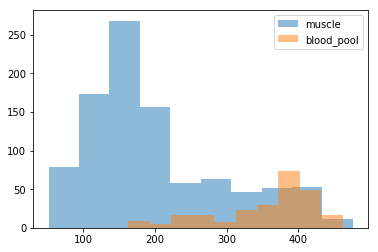

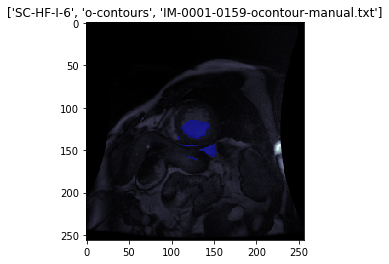

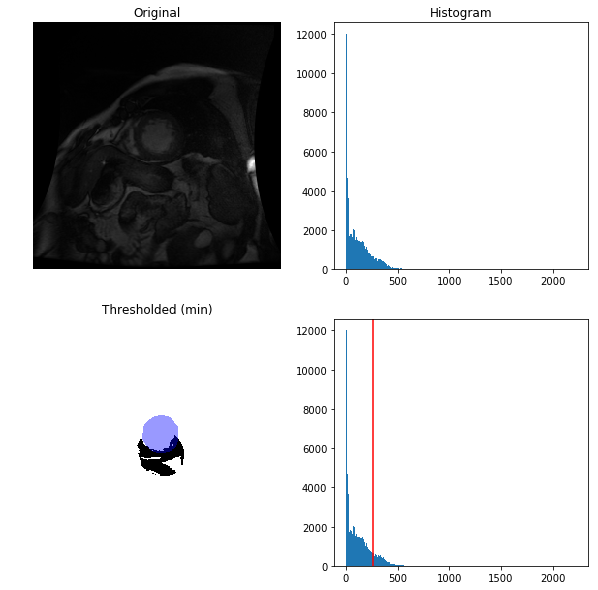

Ks_2sampResult(statistic=0.1510204081632653, pvalue=0.0016138155292159495) iou: 0.42358078602620086


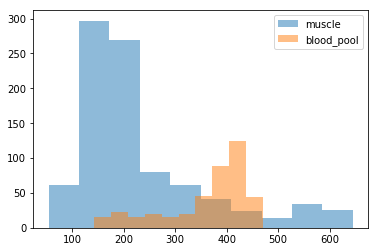

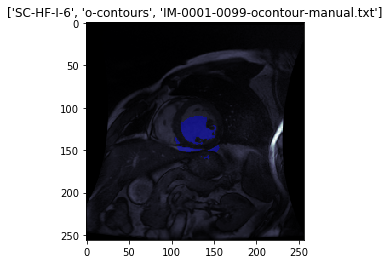

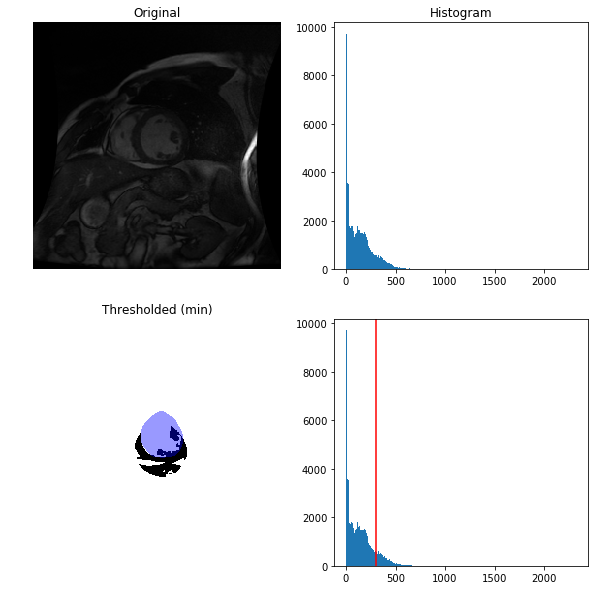

Ks_2sampResult(statistic=0.20287404076445573, pvalue=1.3113661888422991e-08) iou: 0.5380710659898477


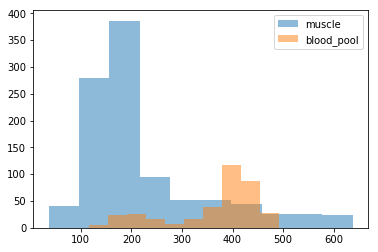

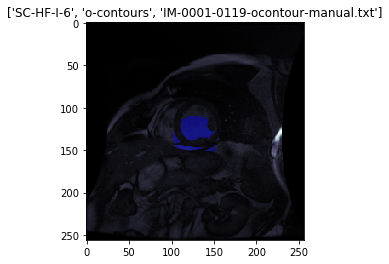

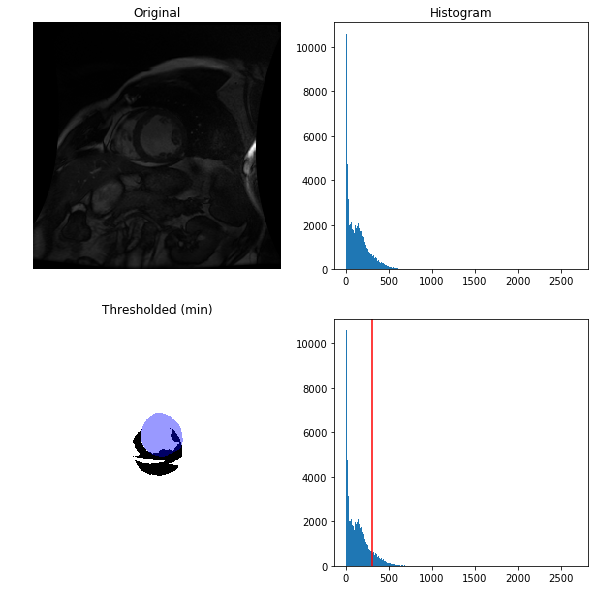

Ks_2sampResult(statistic=0.21095890410958903, pvalue=1.2189164689560041e-08) iou: 0.5097345132743363


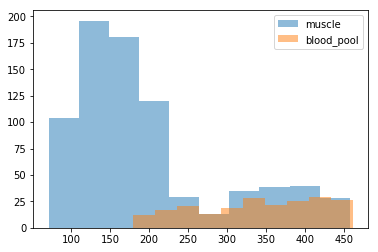

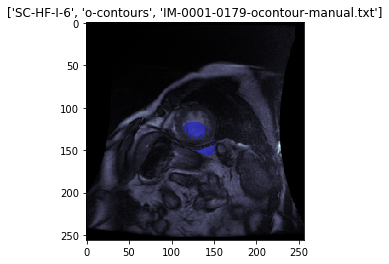

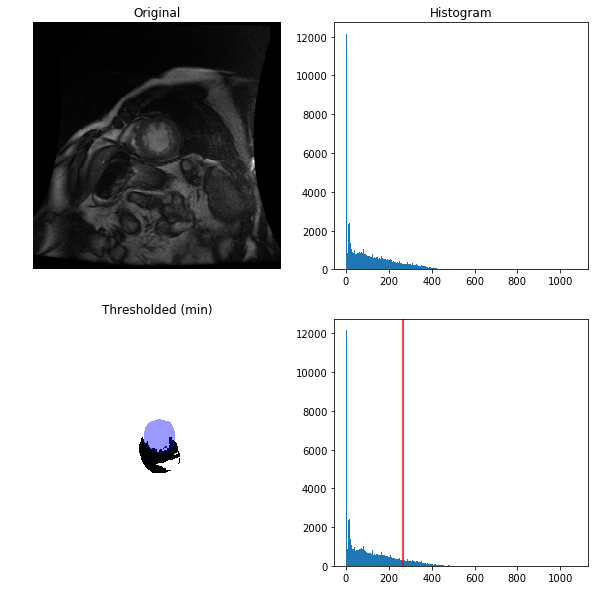

Ks_2sampResult(statistic=0.25508937437934454, pvalue=1.1934172708279938e-07) iou: 0.4293628808864266


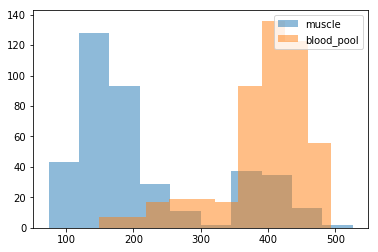

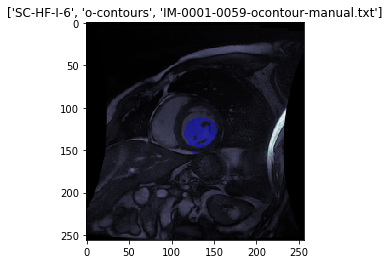

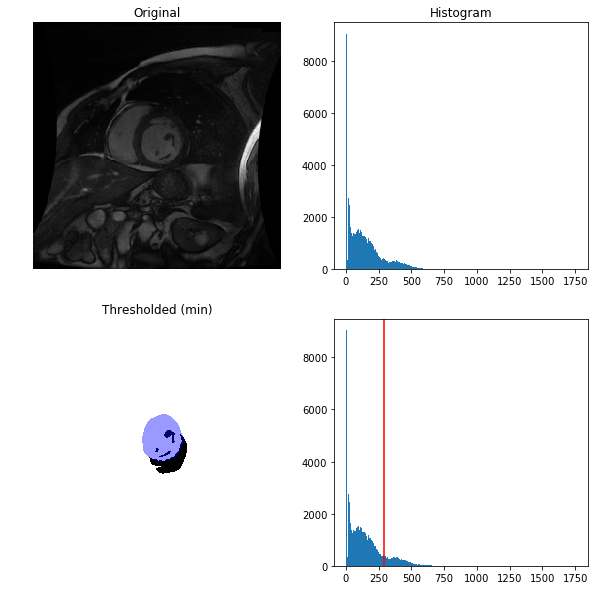

Ks_2sampResult(statistic=0.10904678127053435, pvalue=0.010894983343634932) iou: 0.7244094488188977


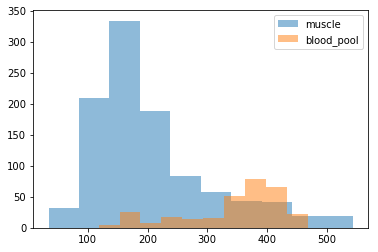

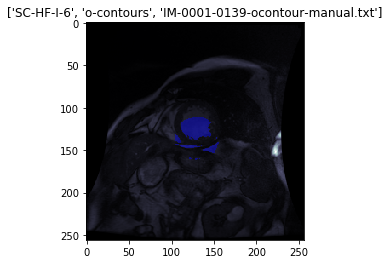

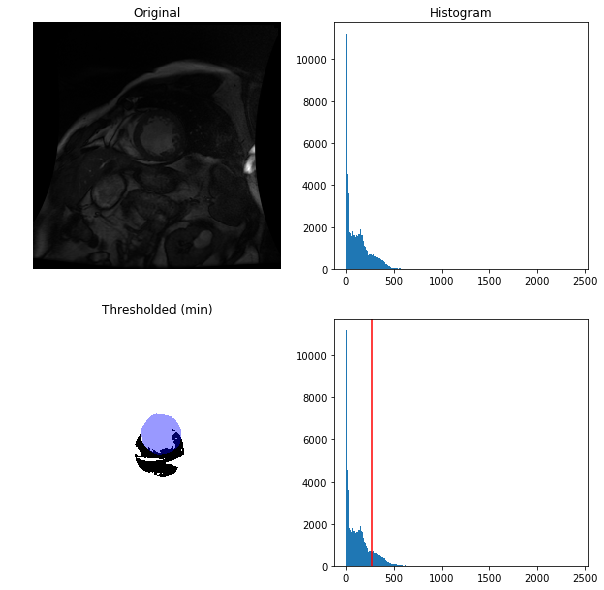

Ks_2sampResult(statistic=0.20065789473684212, pvalue=8.838086470326615e-07) iou: 0.48185483870967744


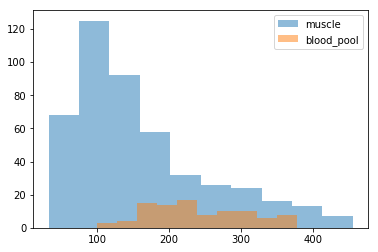

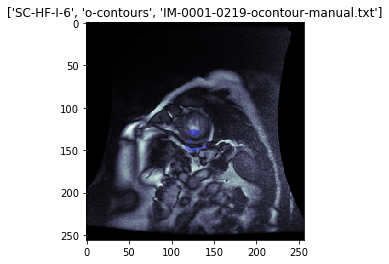

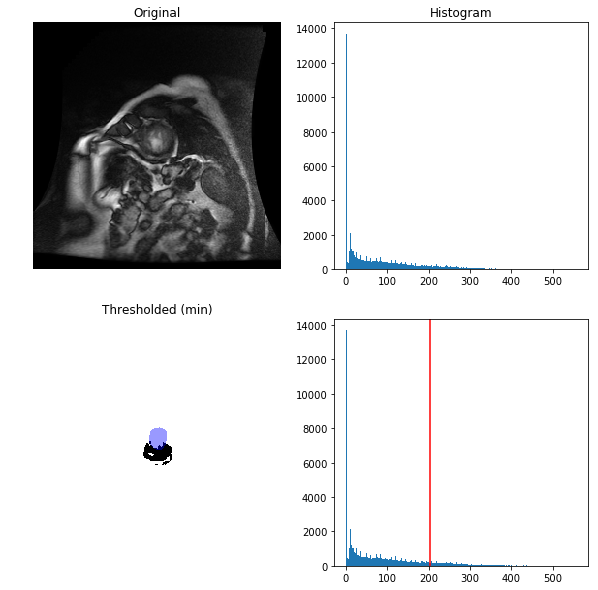

Ks_2sampResult(statistic=0.3478563959567793, pvalue=9.005859154247078e-07) iou: 0.24242424242424243


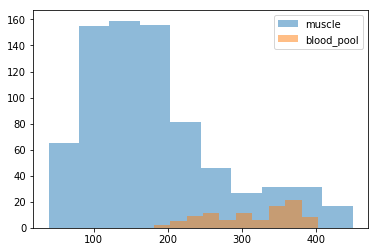

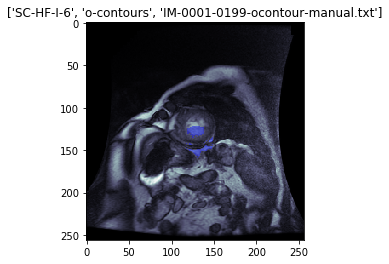

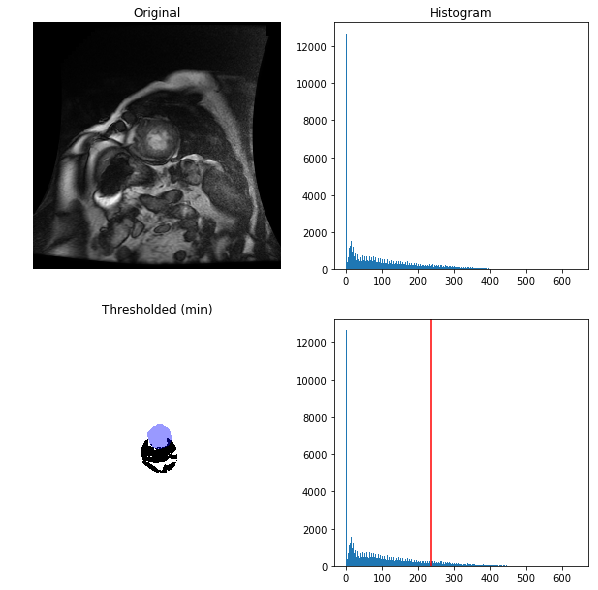

Ks_2sampResult(statistic=0.14583333333333334, pvalue=0.10609710538658297) iou: 0.2845528455284553


In [21]:
ks_score_dict={}
ious=[]
ks_score=[]

for k in rings.keys():
    plot_densityHist(k)
    k, ks2samp_score, iou_val = visual_report(k, plot=True) 

    ks_score_dict[k]=ks2samp_score
    ious.append(iou_val)
    ks_score.append(ks2samp_score.pvalue)


In [30]:
# ious

In [19]:
high =[x for x in ious if x > .75]
print(high)
print(len(high)/len(ks_score))

[0.8961892247043364, 0.8404118404118404, 0.8222490931076178, 0.8577929465301479, 0.7877906976744186, 0.8920353982300885, 0.8013029315960912, 0.809437386569873, 0.910757946210269, 0.8204592901878914, 0.8690807799442897, 0.8645066273932254, 0.8450363196125908, 0.8203592814371258, 0.8242730720606827, 0.7925531914893617, 0.7866492146596858, 0.9294736842105263, 0.8130990415335463, 0.8461538461538461, 0.8874709976798144, 0.7954110898661568, 0.919602529358627, 0.773841961852861, 0.9235181644359465, 0.8194726166328601, 0.9328621908127208, 0.7716262975778547, 0.7883333333333333, 0.8243559718969555]
0.6521739130434783


In [20]:
ks_score
lowp =[x for x in ks_score if x < .05]
print(lowp)
print(len(lowp)/len(ks_score))

[0.004954731716717515, 1.923471946910689e-07, 3.088433199072634e-10, 1.8947709647188846e-07, 1.8618976900370743e-12, 2.7427586156123836e-14, 3.187846582588472e-27, 2.5123480548856657e-08, 0.0038206613869173588, 6.776339087079762e-13, 0.0032541258608668974, 1.3550662324648827e-08, 2.8665600907100636e-06, 2.5826630855714996e-11, 2.2503645946478576e-06, 0.0010644098062399798, 1.1812102179607453e-07, 0.011531659522234464, 0.02645608608859466, 1.45830178098309e-10, 0.017062980365123277, 3.97040596321661e-11, 2.1975513016067763e-11, 5.929336966841e-16, 1.1087753086141617e-06, 0.0007294500097772135, 1.3198680584995774e-07, 0.0016138155292159495, 1.3113661888422991e-08, 1.2189164689560041e-08, 1.1934172708279938e-07, 0.010894983343634932, 8.838086470326615e-07, 9.005859154247078e-07]
0.7391304347826086
